In [6]:
from tensorflow.keras.models import load_model, clone_model
import numpy as np
from glob import glob
import mne
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random

In [2]:
model_paths = ["../model/client_model{}.h5".format(i) for i in range(10)]
models = [load_model(model_path) for model_path in model_paths]

In [3]:
test_model=clone_model(models[4])
test_model.compile('adam',loss='binary_crossentropy',metrics=['Accuracy', 'Precision', 'Recall','AUC'])

In [4]:
all_files_path=glob('../test/*.edf')
print(len(all_files_path))
healthy_file_path=[i for i in all_files_path if  'H' in i.split('\\')[1]]
patient_file_path=[i for i in all_files_path if  'M' in i.split('\\')[1]]

print(len(healthy_file_path),len(patient_file_path))
def read_data(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    # Select a specific channel
    channel_to_keep = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE']  
      
    # Replace with the name of the channel you want to keep
    raw.pick_channels(channel_to_keep)
    raw.set_eeg_reference()
    raw.filter(l_freq=30,h_freq=100)#1-4=delta, 4-8=theta, 8-12=alpha, 12-30=beta, 30-100=gamma
    epochs=mne.make_fixed_length_epochs(raw,duration=15,overlap=1)
    epochs=epochs.get_data()
    scaler = StandardScaler()
    data = scaler.fit_transform(epochs.reshape(-1,epochs.shape[-1])).reshape(epochs.shape)
    return data #trials,channel,length

18
9 9


In [5]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [7]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))


data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels

# combined_list = [item for pair in zip(X, y) for item in pair]
combined_list = [[a, b] for a, b in zip(data_list, label_list)]

# Shuffle the combined pairs randomly
random.shuffle(combined_list)
data_list = [pair[0] for pair in combined_list]
label_list = [pair[1] for pair in combined_list]

print(len(data_list),len(label_list))
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
data_array=np.moveaxis(data_array,1,2)

9 9
18 18


In [8]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0) #Sum of array elements over a given axis.
	# argmax across classes
	result = np.argmax(summed, axis=1)#Returns the indices of the maximum values along an axis.
	
	return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	
	return accuracy_score(testy, yhat)

In [9]:
def average_model_prediction(models, testX):
    predictions = [model.predict(testX) for model in models]
    average_prediction = np.mean(predictions, axis=0)
    return average_prediction

In [10]:
# def weighted_arithmetic_mean(members, n_members, testX, weights):
#     subset = members[:n_members]
#     predictions = [model.predict(testX) for model in subset]
    
#     if len(predictions) != len(weights):
#         raise ValueError("Number of models and weights should be the same.")

#     weighted_sum = np.zeros_like(predictions[0])

#     for i in range(len(predictions)):
#         weighted_sum += weights[i] * predictions[i]

#     total_weight = np.sum(weights)
#     weighted_mean = weighted_sum / total_weight

#     return weighted_mean

def weighted_arithmetic_mean_accuracy(models, n_members, testX, weights):
    subset = models[:n_members]
    single_scores = [model.evaluate(testX, label_array)[1] for model in subset]

    if len(single_scores) != len(weights):
        raise ValueError("Number of models and weights should be the same.")

    weighted_mean_accuracy = np.average(single_scores, weights=weights) #Compute the weighted average along the specified axis.

    return weighted_mean_accuracy

In [11]:
single_scores = []
single_scores_avg=[]
ensemble_scores = []
weighted_mean_scores = []
weighted_mean_scores_2x = []
weighted_mean_scores_4x = []
weighted_mean_scores_6x = []
weighted_mean_scores_8x = []
weighted_mean_scores_10x = []
average_scores=[]

for i in range(1, len(models)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(models, i, data_array, label_array)
    
    # evaluate the i'th model standalone
    single_score = models[i-1].evaluate(data_array, label_array)
    single_scores.append(single_score[1])

    #  Use the provided function to calculate the weighted mean accuracy
    # single_scores_avg.append(single_score[1]*2)
    weighted_mean_accuracy = weighted_arithmetic_mean_accuracy(models, i, data_array, single_scores)
    # weighted_mean_accuracy_2x = weighted_arithmetic_mean_accuracy(models, i, data_array, [x * 2 for x in single_scores])
    # weighted_mean_accuracy_4x = weighted_arithmetic_mean_accuracy(models, i, data_array, [x * 4 for x in single_scores])
    # weighted_mean_accuracy_6x = weighted_arithmetic_mean_accuracy(models, i, data_array, [x * 6 for x in single_scores])
    # weighted_mean_accuracy_8x = weighted_arithmetic_mean_accuracy(models, i, data_array, [x * 8 for x in single_scores])
    # weighted_mean_accuracy_10x = weighted_arithmetic_mean_accuracy(models, i, data_array,[x * 10 for x in single_scores])

   
    # Calculate the average model prediction
    average_model_prediction_labels = average_model_prediction(models[:i], data_array)
    average_model_prediction_labels = (average_model_prediction_labels > 0.5).astype(int)
    average_model_accuracy = accuracy_score(label_array, average_model_prediction_labels)
   
    
    
    
    average_scores.append(average_model_accuracy)    
    ensemble_scores.append(ensemble_score)
    weighted_mean_scores.append(weighted_mean_accuracy)
    # weighted_mean_scores_2x.append(weighted_mean_accuracy_2x)
    # weighted_mean_scores_4x.append(weighted_mean_accuracy_4x)
    # weighted_mean_scores_6x.append(weighted_mean_accuracy_6x)
    # weighted_mean_scores_8x.append(weighted_mean_accuracy_8x)
    # weighted_mean_scores_10x.append(weighted_mean_accuracy_10x)


    # summarize this step
    # print(average_model_prediction_labels)
    print('> %d: single=%.3f, ensemble=%.3f, weighted=%.3f, average=%.3f' % (i, single_score[1], ensemble_score, weighted_mean_accuracy, average_model_accuracy))

17/17 [==============================] - 0s 18ms/step
> 1: single=0.473, ensemble=0.473, weighted=0.473, average=0.473
17/17 [==============================] - 0s 18ms/step
> 2: single=0.473, ensemble=0.473, weighted=0.473, average=0.473
17/17 [==============================] - 0s 18ms/step
> 3: single=0.473, ensemble=0.473, weighted=0.473, average=0.473
17/17 [==============================] - 0s 18ms/step
> 4: single=0.473, ensemble=0.473, weighted=0.473, average=0.473
17/17 [==============================] - 0s 18ms/step
> 5: single=0.775, ensemble=0.473, weighted=0.561, average=0.473
17/17 [==============================] - 0s 18ms/step
> 6: single=0.527, ensemble=0.473, weighted=0.555, average=0.473
17/17 [==============================] - 0s 18ms/step
> 7: single=0.527, ensemble=0.473, weighted=0.551, average=0.473
17/17 [==============================] - 0s 18ms/step
> 8: single=0.527, ensemble=0.473, weighted=0.548, average=0.680
17/17 [==============================] - 0s 18ms

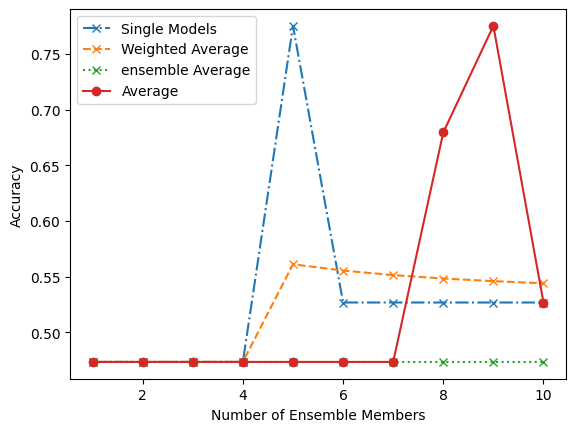

In [12]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1,len(models)+1)]
pyplot.plot(x_axis, single_scores, marker='x', linestyle='-.',label='Single Models')
# pyplot.plot(x_axis, weighted_mean_scores_2x, marker='o', linestyle='dashed',label='Weighted Average 2x')
# pyplot.plot(x_axis, weighted_mean_scores_4x, marker='o', linestyle='dashed',label='Weighted Average 4x')
# pyplot.plot(x_axis, weighted_mean_scores_6x, marker='o', linestyle='dashed',label='Weighted Average 6x')
# pyplot.plot(x_axis, weighted_mean_scores_8x, marker='o', linestyle='dashed',label='Weighted Average 8x')
# pyplot.plot(x_axis, weighted_mean_scores_10x, marker='o', linestyle='dashed',label='Weighted Average 10x')
pyplot.plot(x_axis, weighted_mean_scores, marker='x', linestyle='dashed',label='Weighted Average')
pyplot.plot(x_axis, ensemble_scores, marker='x',linestyle="dotted",label='ensemble Average')
pyplot.plot(x_axis, average_scores, marker='o',linestyle="-",label='Average')
pyplot.xlabel('Number of Ensemble Members')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

In [ ]:
# evaluate different numbers of ensembles on hold out set
single_scores=[]
ensemble_scores = []
weighted_mean_scores=[]
avg_scores=[]

for i in range(1,len(models)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(models, i, data_array, label_array)
	# evaluate the i'th model standalone
	# testy_enc = to_categorical(label_array)
	
	single_score = models[i-1].evaluate(data_array, label_array)

	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score[1])

	avg_score= avg_score(models, i, data_array, label_array)
	avg_scores.append(avg_score)

	
	# Use the provided function to calculate the weighted mean 
	weighted_mean_result = weighted_arithmetic_mean(models, i, data_array, single_scores)
	# Assuming 'weighted_mean_result' is the result obtained from the weighted arithmetic mean
	binary_predictions = (weighted_mean_result > 0.5).astype(int)
	# Calculate accuracy
	weighted_mean_accuracy = accuracy_score(label_array, binary_predictions)
	

	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f, weighted=%.3f' % (i, single_score[1], ensemble_score, weighted_mean_accuracy))
	
	weighted_mean_scores.append(weighted_mean_accuracy)